In [13]:
import pandas as pd
import os
from pathlib import Path
import csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import json

# Data reading

In [7]:
rootpath=os.getcwd()
# go to the upper directory of rootpath
rootpath=Path(rootpath).parents[0]
#rootpath= './Thesis/Dataanalyse/'
rootpath
df=pd.read_csv(os.path.join(rootpath,'Dataanalyse/axis2_demo_tablepart1_0.csv'))
df.head()
with open (os.path.join(rootpath,'Dataanalyse/important_features.json'), 'r') as f:
    features = json.load(f)[:12]
features=['Schadensklasse']+features
newdf=df[features]
newdf.rename(columns={'Schadensklasse':'classe'},inplace=True)
newdf.to_csv('gan_axis2_demo.csv',index=False)


WindowsPath('d:/studydata/Masterarbeit/lian333/Thesis')

# model

In [45]:
# Load iris dataset
iris = pd.read_csv('gan_axis2_demo.csv')
X = iris.drop('classe', axis=1)  # we only take the first four features.
y = iris.classe

# Normalize the data
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

# Convert data to pandas DataFrame
real_data = pd.DataFrame(X)
real_labels = y

# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_labels = one_hot_encoder.fit_transform(np.array(real_labels).reshape(-1, 1))
# Constants
NOISE_DIM = 100
NUM_CLASSES = 3
NUM_FEATURES = 12
BATCH_SIZE = 64
TRAINING_STEPS = 500

# Generator
def create_generator():
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([noise_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(NUM_FEATURES, activation='linear')(hidden)
    model = Model(inputs=[noise_input, class_input], outputs=output)
    return model

# Discriminator
def create_discriminator():
    data_input = Input(shape=(NUM_FEATURES,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=[data_input, class_input], outputs=output)
    return model

# cGAN
def create_cgan(generator, discriminator):
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])
    validity = discriminator([generated_data, class_input])
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

# Create and compile the Discriminator
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

# Create the Generator
generator = create_generator()

# Create the GAN
gan = create_cgan(generator, discriminator)

# Ensure that only the generator is trained
discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer=Adam())


# Train GAN
for step in range(TRAINING_STEPS):
    # Select a random batch of real data with labels
    idx = np.random.randint(0, real_data.shape[0], BATCH_SIZE)
    real_batch = real_data.iloc[idx].values
    labels_batch = one_hot_labels[idx]

    # Generate a batch of new data
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    generated_batch = generator.predict([noise, labels_batch])

    # Train the discriminator
    real_loss = discriminator.train_on_batch([real_batch, labels_batch], np.ones((BATCH_SIZE, 1)))
    fake_loss = discriminator.train_on_batch([generated_batch, labels_batch], np.zeros((BATCH_SIZE, 1)))
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train the generator
    generator_loss = gan.train_on_batch([noise, labels_batch], np.ones((BATCH_SIZE, 1)))

    if step % 100 == 0:
        print(f"Step: {step}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

# Generate instances for a given class
def generate_data(generator, data_class, num_instances):
    one_hot_class = one_hot_encoder.transform(np.array([[data_class]]))
    noise = np.random.normal(0, 1, (num_instances, NOISE_DIM))
    generated_data = generator.predict([noise, np.repeat(one_hot_class, num_instances, axis=0)])
    return pd.DataFrame(generated_data)

# Generate 40 instances of class 1
generated_data = generate_data(generator, 1, 40)
print(generated_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


d:\app\conda_test\finaltest\lib\site-packages\keras\src\backend\tensorflow\trainer.py:74: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Step: 0, Discriminator Loss: 0.7652807235717773, Generator Loss: 0.6943129301071167
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2

['Standardabweichung_y',
 'Variance_z',
 'Variance_y',
 'Standardabweichung_z',
 'Effektivwert_x',
 'Mittlere_Absolute_Abweichung_y',
 'Effektivwert_y',
 'Standardabweichung_x',
 'Mittelwert_x',
 'Variance_x',
 'Mittlere_Absolute_Abweichung_x',
 'Mittlere_Absolute_Abweichung_z']

In [48]:
with open ('important_features.json', 'r') as f:
    features = json.load(f)[:12]
features



# Generate 50 instances for each class
synthetic_data_class_0 = generate_data(generator, 0, 50)
synthetic_data_class_1 = generate_data(generator, 1, 50)
synthetic_data_class_2 = generate_data(generator, 2, 50)

# Combine all synthetic data into a single DataFrame and apply inverse transform to bring it back to original scale
synthetic_data = pd.concat([synthetic_data_class_0, synthetic_data_class_1, synthetic_data_class_2], ignore_index=True)
synthetic_data = pd.DataFrame(scaler.inverse_transform(synthetic_data), columns=features)

# Create corresponding class labels
synthetic_labels = [0]*50 + [1]*50 + [2]*50

# Add labels to the synthetic data
synthetic_data['class'] = synthetic_labels

# Save synthetic data as a CSV file
synthetic_data.to_csv(r'D:\studydata\Masterarbeit\Data\gan\axis2data.csv', index=False)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(10000, 12)

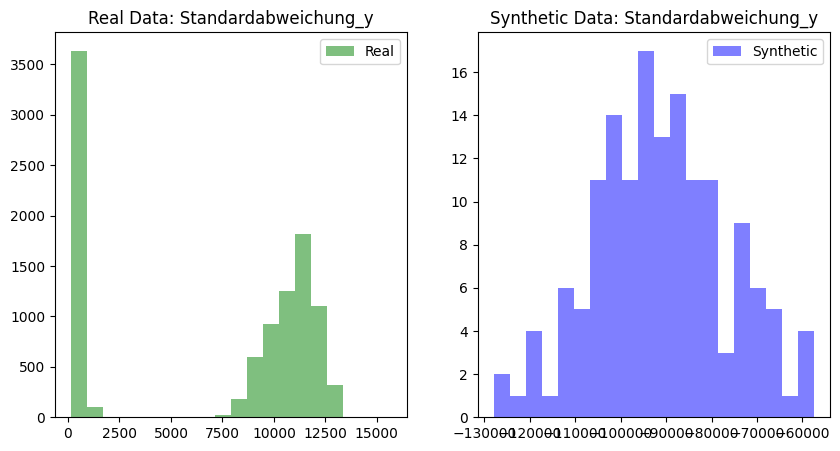

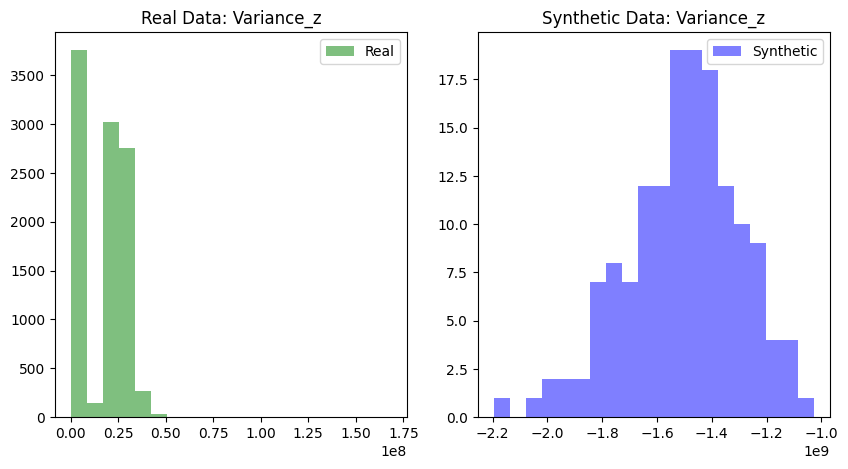

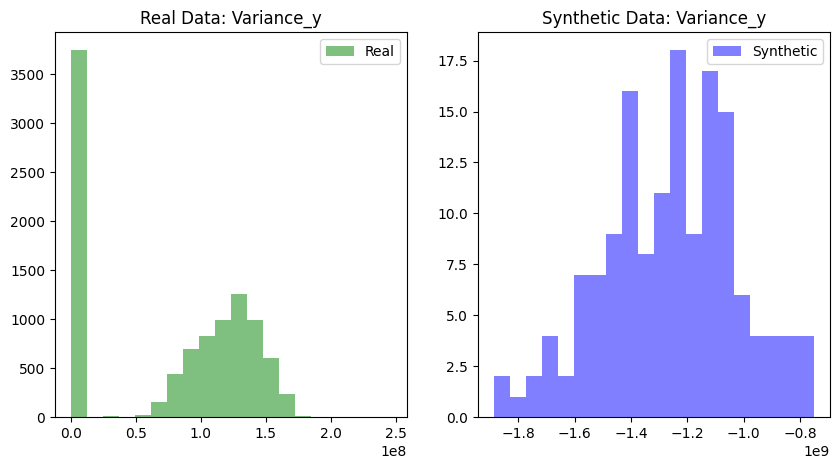

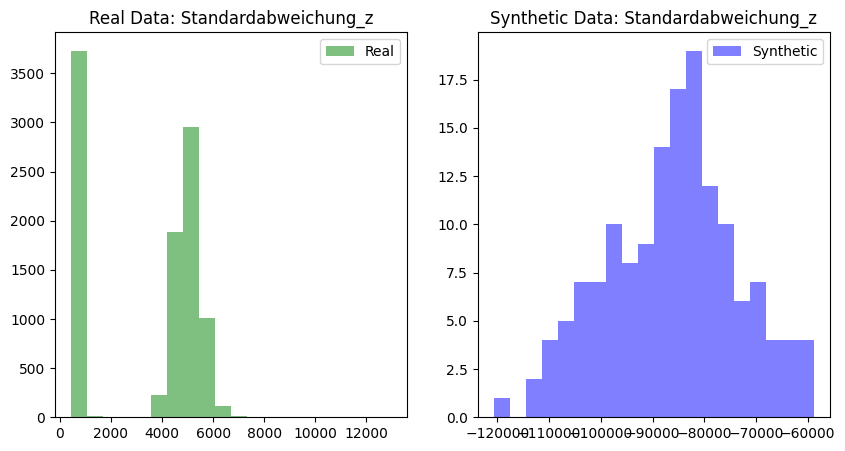

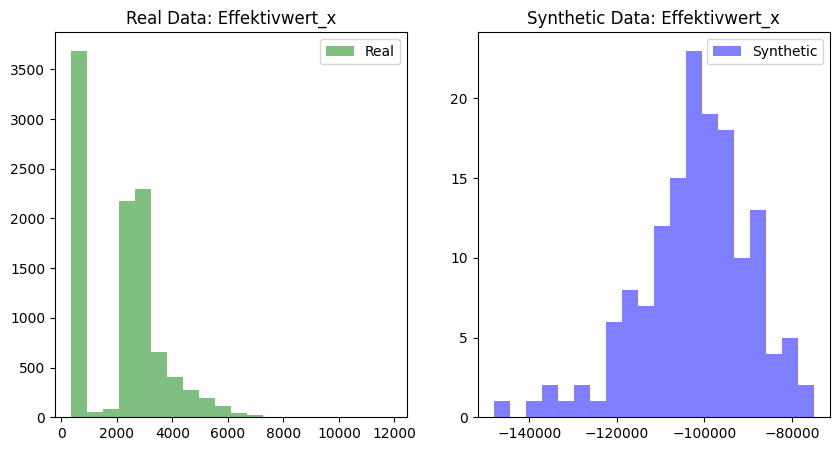

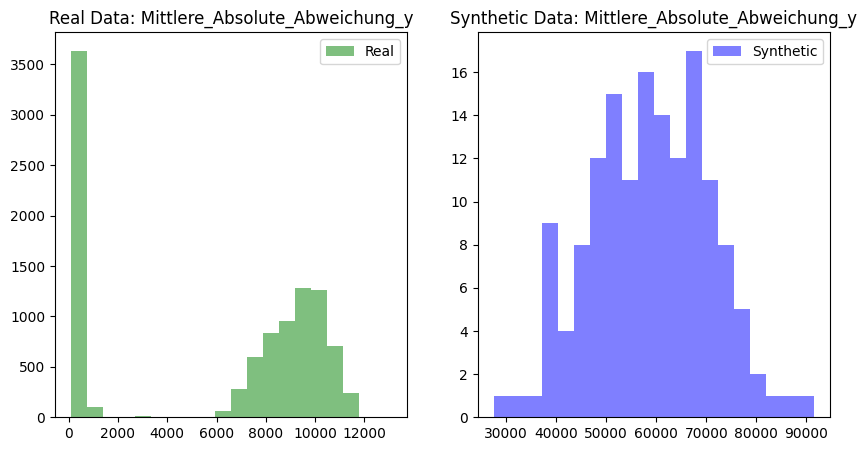

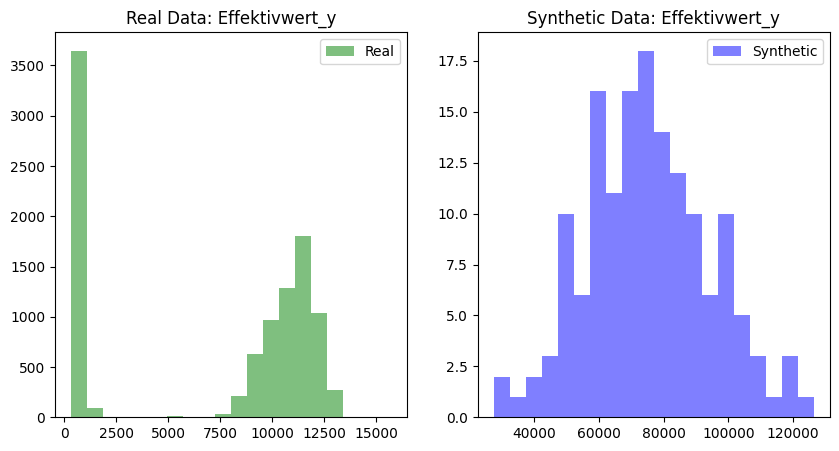

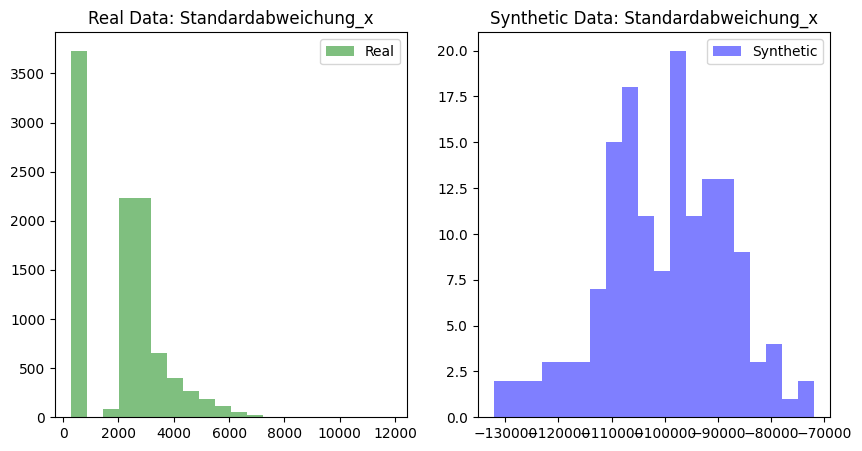

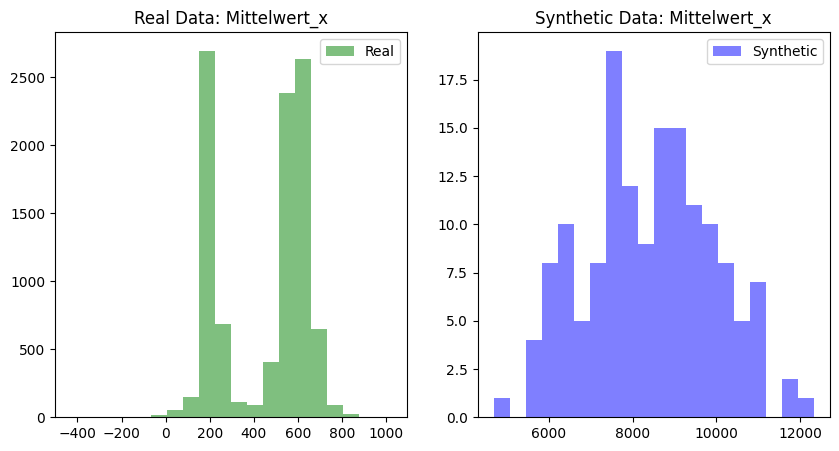

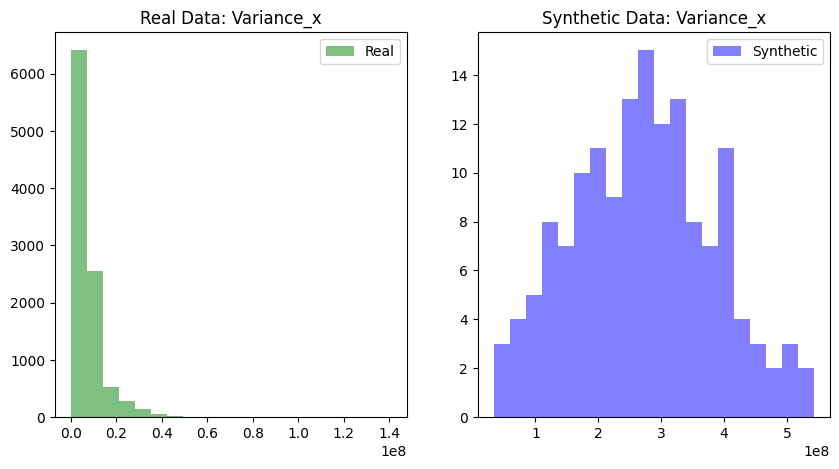

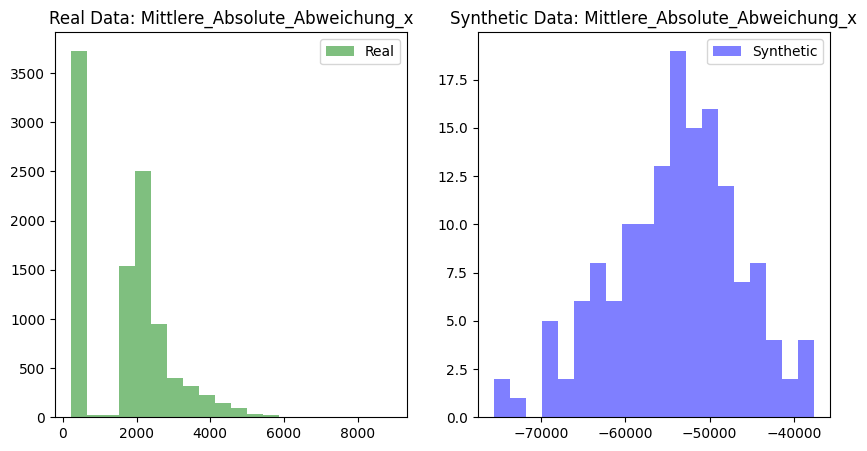

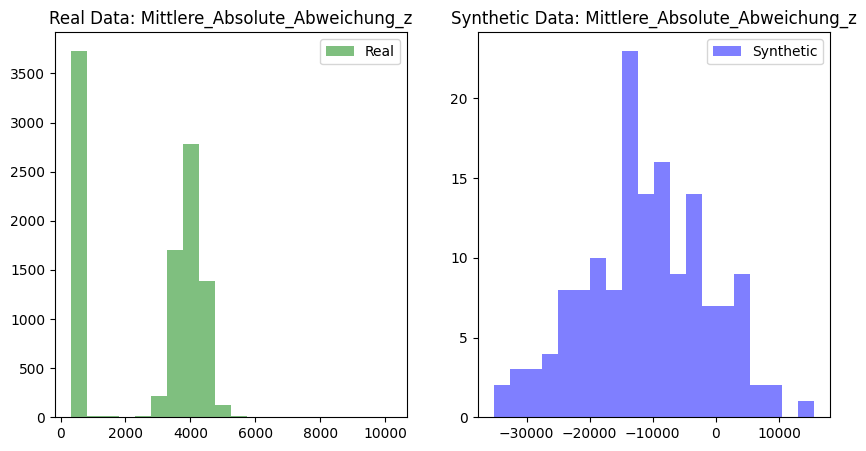

Summary statistics for the real data:
       Standardabweichung_y    Variance_z    Variance_y  Standardabweichung_z  \
count          10000.000000  1.000000e+04  1.000000e+04          10000.000000   
mean            6898.241758  1.620075e+07  7.535183e+07           3343.462942   
std             5262.462994  1.340066e+07  6.139386e+07           2237.477815   
min              139.119000  1.831380e+05  1.937340e+04            427.733000   
25%              162.027500  2.524305e+05  2.627912e+04            502.173500   
50%             9870.270000  2.120470e+07  9.751980e+07           4602.545000   
75%            11360.525000  2.655645e+07  1.291912e+08           5150.715000   
max            15691.800000  1.685270e+08  2.464780e+08          12975.300000   

       Effektivwert_x  Mittlere_Absolute_Abweichung_y  Effektivwert_y  \
count    10000.000000                    10000.000000    10000.000000   
mean      2106.621527                     5827.234766     6986.106952   
std       146

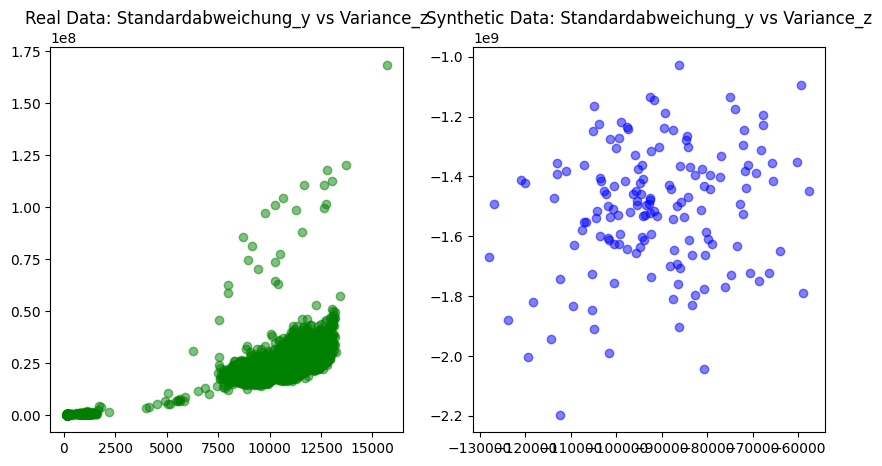

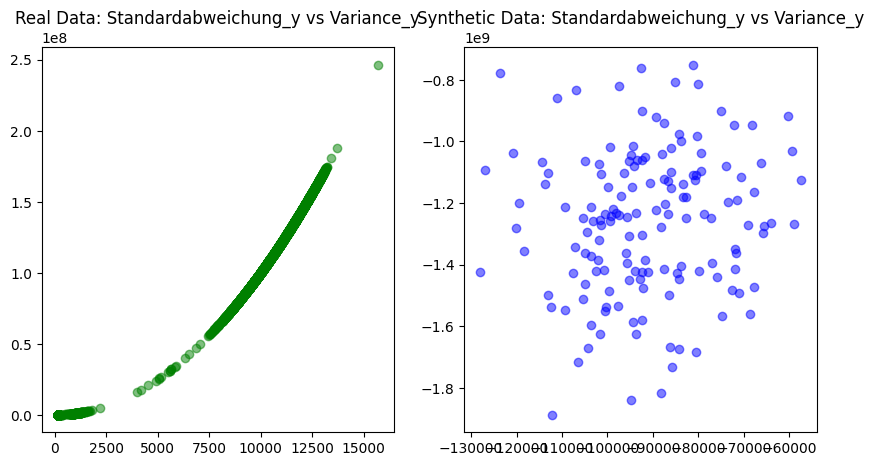

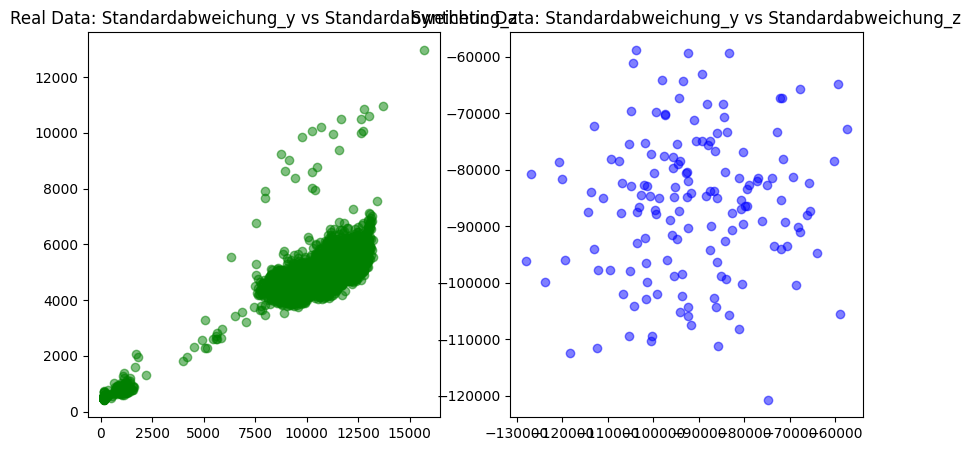

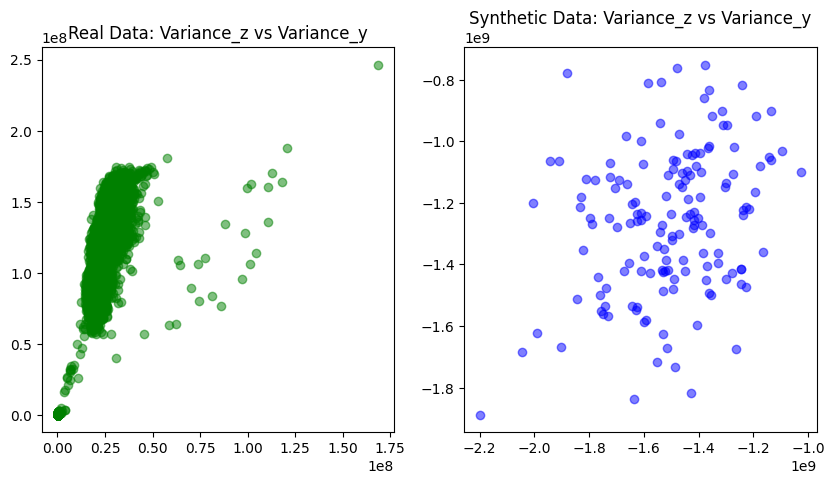

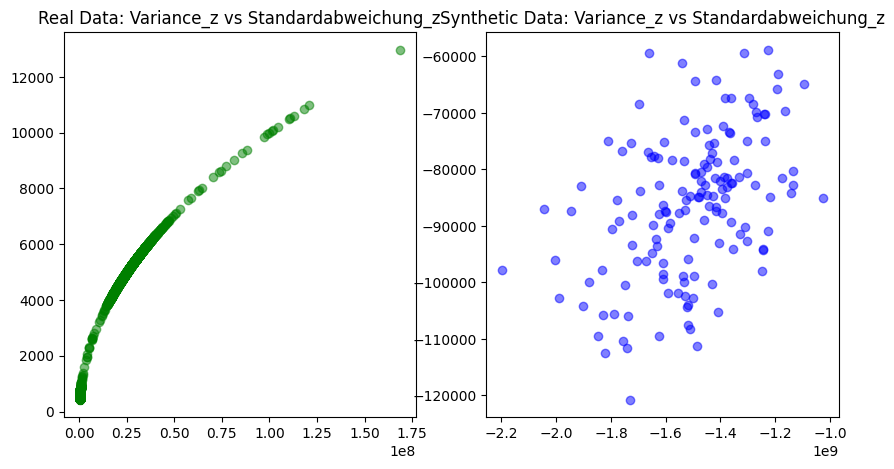

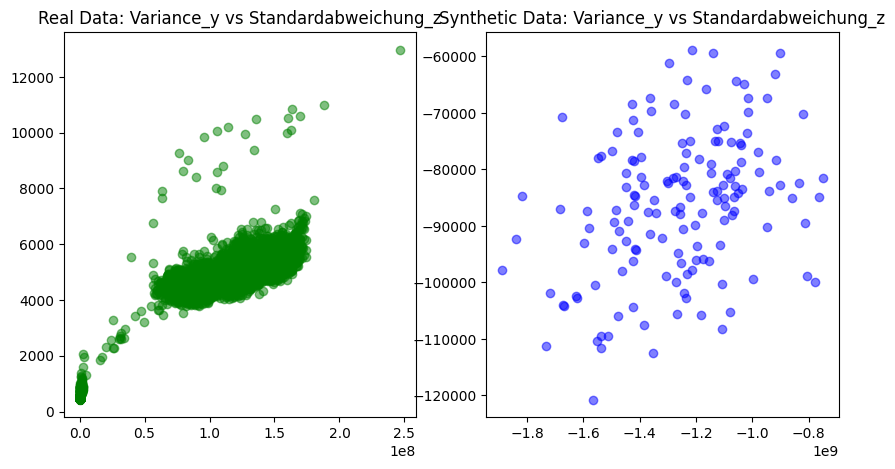

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

# Load the Iris dataset from sklearn
iris = pd.read_csv('gan_axis2_demo.csv')
real_data = iris.drop('classe', axis=1)  # we only take the first four features.
y = iris.classe
with open ('important_features.json', 'r') as f:
    features = json.load(f)[:12]
# Load the synthetic dataset
synthetic_data = pd.read_csv(r'D:\studydata\Masterarbeit\Data\gan\axis2data.csv')

# For each feature, create a histogram for the real and synthetic data
for feature in features:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(real_data[feature], bins=20, alpha=0.5, color='g', label='Real')
    plt.title(f"Real Data: {feature}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(synthetic_data[feature], bins=20, alpha=0.5, color='b', label='Synthetic')
    plt.title(f"Synthetic Data: {feature}")
    plt.legend()

    plt.show()

# Print the summary statistics for the real and synthetic data
print("Summary statistics for the real data:")
print(real_data.describe())
print("\nSummary statistics for the synthetic data:")
print(synthetic_data.describe())

# For each pair of features, create a scatter plot for the real and synthetic data
features = features[:4]
for i in range(len(features)):
    for j in range(i+1, len(features)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(real_data[features[i]], real_data[features[j]], alpha=0.5, color='g')
        plt.title(f"Real Data: {features[i]} vs {features[j]}")

        plt.subplot(1, 2, 2)
        plt.scatter(synthetic_data[features[i]], synthetic_data[features[j]], alpha=0.5, color='b')
        plt.title(f"Synthetic Data: {features[i]} vs {features[j]}")

        plt.show()